In [2]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
img = cv2.imread("assets/city.jpg", cv2.IMREAD_UNCHANGED)[..., ::-1]

In [5]:
kernel_size = 5
filtered_opencv = cv2.medianBlur(img, kernel_size)
filtered_opencv.shape

(333, 500, 3)

### Простая имплементация через циклы

In [6]:
def median_filter_naive(img, kernel_size):
    assert kernel_size % 2 != 0, "Kernel size should be odd"
    
    H, W, C_in = img.shape
    pad = (kernel_size - 1) // 2
    padded_img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="edge")
    out = np.zeros_like(img)
    for c in range(C_in):
        for i in range(H):
            for j in range(W):
                window = padded_img[i:i+kernel_size, j:j+kernel_size, c]
                out[i, j, c] = np.median(window.flatten())
    return out.astype(np.uint8)

In [7]:
filtered_naive = median_filter_naive(img, kernel_size)
filtered_naive.shape

(333, 500, 3)

In [8]:
np.testing.assert_almost_equal(filtered_opencv, filtered_naive)

### Имплементация через im2col

In [9]:
def im2col_3d(im, kernel_size):
    H, W, C_in = im.shape
    im = np.transpose(im, (2, 0, 1))
    HH = H - kernel_size + 1
    WW = W - kernel_size + 1

    rows = np.empty(shape=(kernel_size*kernel_size, C_in*HH*WW))

    for c in range(C_in):
        for hh in range(HH):
            for ww in range(WW):
                window = im[c, hh:hh+kernel_size, ww:ww+kernel_size]
                rows[:, (c*HH + hh)*WW + ww] = window.flatten()
    return rows


In [10]:
def median_filter_im2col(img, kernel_size):
    assert kernel_size % 2 != 0, "Kernel size should be odd"

    H, W, C_in = img.shape
    pad = (kernel_size - 1) // 2
    padded_img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="edge")

    rows = im2col_3d(padded_img, kernel_size)
    median_rows = np.median(rows, axis=0)
    median_img = median_rows.reshape((C_in, H, W)).transpose((1, 2, 0))
    return median_img.astype(np.uint8)

In [11]:
filtered_im2col = median_filter_im2col(img, kernel_size=5)

### Сравнение

In [12]:
np.testing.assert_almost_equal(filtered_opencv, filtered_im2col)

In [13]:
np.testing.assert_almost_equal(filtered_opencv, filtered_naive)

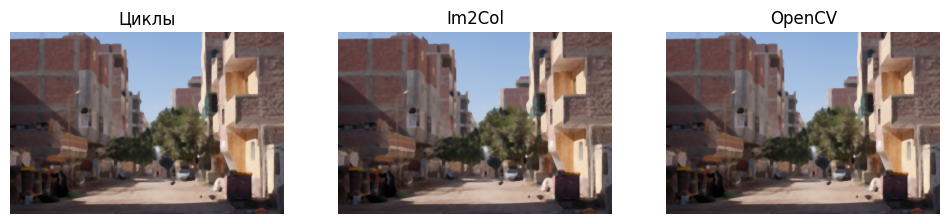

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes[0].imshow(filtered_naive)
axes[0].set_title("Циклы")
axes[0].axis("off")

axes[1].imshow(filtered_im2col)
axes[1].set_title("Im2Col")
axes[1].axis("off")


axes[2].imshow(filtered_opencv)
axes[2].set_title("OpenCV")
axes[2].axis("off")

plt.savefig("assets/comparison.png")